In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
class arguments:
    def __init__(self, cond_block, cond_decoding, applyBaseline_bool, mtdt_feat, occ_channels):
        self.cond_block = cond_block #'later' #{early,later}
        self.cond_decoding = cond_decoding #'removeevoked' #{none,removeevoked,resampled}
        self.applyBaseline_bool = applyBaseline_bool #'False'
        self.mtdt_feat = mtdt_feat
        self.occ_channels = occ_channels
        
        self.SAVE_EPOCH_ROOT = '../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
        self.SAVE_RESULT_ROOT = '../../../results/temp_gen/eCortex/'
        self.cond_filter ='none' # {none,non_symm}
        self.cond_time = 'prestim' #{prestim,poststim}
        self.subj_num = 1
        self.pre_tmin = -0.4
        self.pre_tmax = 0.05
        self.post_tmin = 0.05
        self.post_tmax = 0.45
        self.num_classes = 2
        self.normalization_type = 'normal'# {normal,lstmPaper}
        self.gen_rand_perm = 0
        self.null_max_iter = 10000
        self.loop_null_iter = 5
        self.gen_decoder_scores = 1
        self.random_state = 42 
        self.max_iter = 10000
        self.n_jobs = 1
        self.scoring = 'roc_auc'
        self.n_splits = '_3k'
        self.smooth_lvl = 55
        self.occ_channels = 'True'
        print(self.SAVE_RESULT_ROOT)

In [3]:
args = arguments('rand', 'removeevoked', 'False', 'Trgt_Loc_main', 'False' )


if args.applyBaseline_bool:
    filename_epoch = args.SAVE_EPOCH_ROOT + \
                     'epochs_sec_applyBaseline_subj%s-afterRejICA-epo.fif' \
                      %args.subj_num
else:
    filename_epoch = args.SAVE_EPOCH_ROOT + \
                     'epochs_sec_subj%s-afterRejICA-epo.fif' \
                     %args.subj_num
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True,
                              verbose=None)
epochs = epochs_orig.copy()
##==========================================================================
if epochs['Block==7'].metadata.Ptrn_Type.values.shape[0]>0:
   main_ptrn = epochs['Block==7'].metadata.Ptrn_Type.values[0]
else:
   main_ptrn = epochs['Block==8'].metadata.Ptrn_Type.values[0]
##==========================================================================
if args.cond_block=='rand':
    subset = epochs['rand']['non'].copy()
else:
    subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
if (args.cond_decoding=='removeevoked'):
    # REMOVE EVOKED RESP.
    subset.subtract_evoked()    # remove evoked response
elif (args.cond_decoding=='resampled'):
    # RESAMPLE
    subset = subset.resample(args.n_resampling, npad='auto')
else:
    pass
##==========================================================================
# Select EEG channels of the back
if args.occ_channels:
    picks_back_brain = ['E56', 'E63', 'E68', 'E73', 'E81', 'E88', 'E94', 'E99', 'E107',
    'E57', 'E64', 'E69', 'E74', 'E82', 'E89', 'E95', 'E100',
    'E50', 'E58', 'E65', 'E70', 'E75', 'E83', 'E90', 'E96', 'E101',
    'E51', 'E59', 'E66', 'E71', 'E76', 'E84', 'E91', 'E97',
    'E52', 'E60', 'E67', 'E72', 'E77', 'E85', 'E92'
    'E53', 'E61', 'E62', 'E78','E86'
    ]
    subset = subset.pick_types(eeg=True, selection=picks_back_brain)
##==========================================================================
if args.cond_block=='early': #block 3-6
    subset = subset['Block<7'].copy()
    subset = subset['Block>2'].copy()
elif args.cond_block=='later':#block 7-10
    subset = subset['Block<11'].copy()
    subset = subset['Block>6'].copy()
elif args.cond_block=='diff':
    se = subset['Block<7'].copy() # early blocks
    se = se['Block>2'].copy()
    print('earlier blocks shape:\n')
    print(se._data.shape)
    sl= subset['Block<11'].copy() # later blocks
    sl = sl['Block>6'].copy()
    print('later blocks shape:\n')
    print(sl._data.shape)
    subset._data=sl._data-se._data
elif args.cond_block=='rand':
    subset = subset['Block<3'].copy()
elif args.cond_block=='b3':
    subset = subset['Block==3'].copy()
elif args.cond_block=='b10':
    subset = subset['Block==10'].copy()
elif args.cond_block=='b34':
    subset = subset['Block<5'].copy()
    subset = subset['Block>2'].copy()
elif args.cond_block=='b910':
    subset = subset['Block<11'].copy()
    subset = subset['Block>8'].copy()


##==========================================================================
subset= subset.crop(tmin=-0.45, tmax=0.45)
print(subset._data.shape)
##==========================================================================
# Group data based on the previous trial
 # Group data based on the current main loc
if  args.cond_block=='rand':
    Grp1 = subset.copy()
    Grp2 = subset.copy()
    Grp3 = subset.copy()
    Grp4 = subset.copy()
    Grps_dt=[]
    Grps_avg=[]
    smooth_evk = [];

../../../results/temp_gen/eCortex/
Reading ../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Subtracting Evoked from Epochs
[done]
(90, 44, 213)


<ipython-input-3-d595401ae631>:77: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset= subset.crop(tmin=-0.45, tmax=0.45)


In [4]:
X = subset._data.copy()
X_2D = X.copy().mean(axis=1)
scaler = StandardScaler()
scaler.fit_transform(X_2D)
Y = subset.metadata['Trgt_Loc_main'].values

[[0.9   2.45  0.17  3.332]
 [1.693 1.821 0.173 3.592]
 [1.165 1.93  0.049 2.552]
 [1.669 2.79  0.202 2.512]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.22      1.00      0.36         6
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8

    accuracy                           0.22        27
   macro avg       0.06      0.25      0.09        27
weighted avg       0.05      0.22      0.08        27



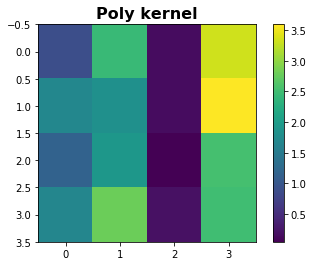

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

cms=[]
crs=[]
for ii in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.3)
    svclassifier = SVC(kernel='poly', degree=100, C=1, gamma=10, decision_function_shape='ovo', random_state=111)
    svclassifier.fit(x_train, y_train)
    y_pred = svclassifier.predict(x_test)
    cms.append(confusion_matrix(y_test, y_pred))
    crs.append(classification_report(y_test, y_pred))

cm = np.mean(np.array(cms), axis=0)
cr = crs[-1]

im = plt.imshow(cm)
plt.colorbar(im)
plt.title('Poly kernel', fontweight='bold', fontsize=16)
print(cm)
print(cr)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(x_train)
pca_2d = pca.transform(x_train)

-46.72787463453413 186.5653817322909
-17.780336389181457 30.19112965683397
-4.5727874634534135e-05
(5, 24)
(5, 24)


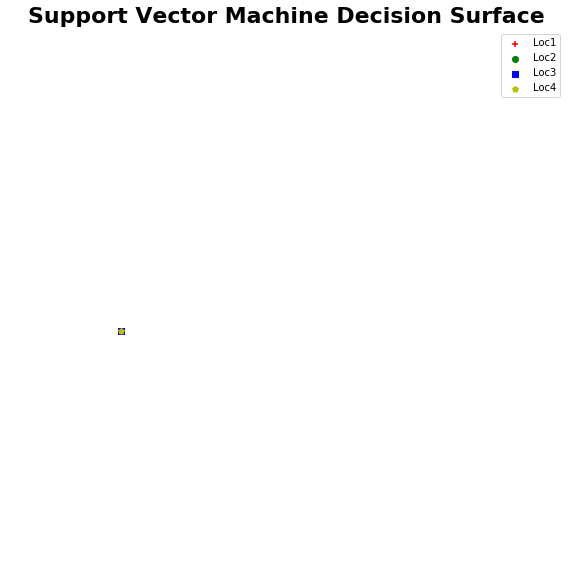

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
done


In [23]:
import matplotlib.pylab as pl

fig= plt.figure(figsize=(10,10))

for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 1:
        c0 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',  marker='+')
    elif y_train[i] == 2:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    marker='o')
    elif y_train[i] == 3:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',    marker='s')
    elif y_train[i] == 4:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',    marker='p')
        
pl.legend([c0, c1, c2, c3], ['Loc1', 'Loc2', 'Loc3','Loc4'])
pl.title('Training dataset with 3 classes and known outcomes')


svclassifier_2d = SVC(kernel='linear')
svclassifier_2d.fit(pca_2d, y_train)

x_min, x_max = pca_2d[:, 0].min() * 10e5 - 1,   pca_2d[:,0].max() * 10e5 + 1
y_min, y_max = pca_2d[:, 1].min() * 10e5 - 1,   pca_2d[:,1].max() * 10e5 + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))
print(x_min, x_max)
print(y_min, y_max)
print(pca_2d[:, 0].min())
print(xx.shape)

# print(yy.shape)
Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)
print(Z.shape)

pl.contour(xx, yy, Z)
pl.title('Support Vector Machine Decision Surface', fontweight='bold', fontsize=22)
pl.axis('off')
pl.show()


print(Z)
print('done')

# Conclusion:
for some reason, eerything looks like just one location, 
one possible reason could be non-normalized and very small data, even after I used scaler, it is still looking weird!